# spaCy’s Rule-Based Matching
Sebelum kita mulai, mari kita bahas tentang Marti Hearst. Dia adalah seorang peneliti linguistik komputasi dan profesor di School of Information di University of California, Berkeley. Bagaimana dia cocok dengan artikel ini? Saya bisa merasakan Anda bertanya-tanya.
Profesor Marti sebenarnya telah melakukan penelitian ekstensif pada topik ekstraksi informasi. Salah satu penelitiannya yang paling menarik berfokus pada membangun satu set pola teks yang dapat digunakan untuk mengekstrak informasi yang bermakna dari teks. Pola-pola ini dikenal sebagai “Hearst Patterns”.

Let’s look at the example below:
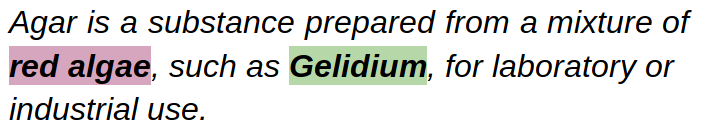

Kita bisa menyimpulkan bahwa "Gelidium" adalah sejenis "red algae" hanya dengan melihat struktur kalimatnya.

Dalam istilah linguistik, kita akan menyebut "ganggang merah" sebagai Hipernim dan "Gelidium" sebagai Hiponimnya.

Kita dapat memformalkan pola ini sebagai "X seperti Y", di mana X adalah hipernim dan Y adalah hiponim. Ini adalah salah satu dari sekian banyak pola dari Pola Hearst. Berikut adalah daftarnya untuk memberi Anda intuisi di balik ide tersebut:

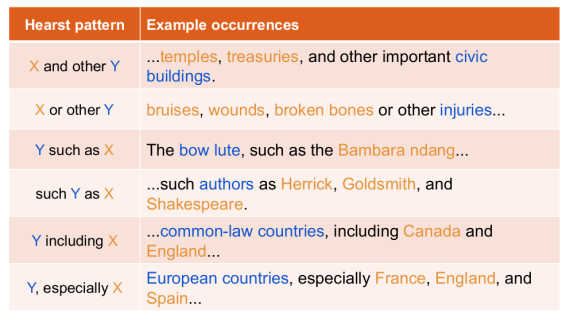

In [ ]:
import re
import math
import nltk
import string
import numpy as np
import pandas as pd
from tqdm import tqdm

import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
from spacy import displacy

pd.set_option('display.max_colwidth', 200)

# load spaCy model
nlp = spacy.load("en_core_web_sm")

- **Pattern: X seperti Y**

In [ ]:
# sample text
text = "GDP in developing countries such as Vietnam will continue growing at a high rate."

# create a spaCy object
doc = nlp(text)

In [ ]:
# print token, dependency, POS tag
for tok in doc:
    print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

GDP --> nsubj --> NOUN
in --> prep --> ADP
developing --> amod --> VERB
countries --> pobj --> NOUN
such --> amod --> ADJ
as --> prep --> ADP
Vietnam --> pobj --> PROPN
will --> aux --> AUX
continue --> ROOT --> VERB
growing --> xcomp --> VERB
at --> prep --> ADP
a --> det --> DET
high --> amod --> ADJ
rate --> pobj --> NOUN
. --> punct --> PUNCT


Have a look around the terms “such” and “as” . They are followed by a noun (“countries”). And after them, we have a proper noun (“Vietnam”) that acts as a hyponym.


In [ ]:
#define the pattern
pattern = [
    {'POS':'NOUN'},
    {'LOWER': 'such'},
    {'LOWER': 'as'},
    {'POS': 'PROPN'}   #proper noun
]

In [ ]:
# Matcher class object
matcher = Matcher(nlp.vocab)
matcher.add("matching_1", [pattern])

matches = matcher(doc) # [(11840699188806025751, 3, 7)]
span = doc[matches[0][1]:matches[0][2]]

print(span.text)

countries such as Vietnam


Nice! It works perfectly. However, if we could get “developing countries” instead of just “countries”, then the output would make more sense.

In [ ]:
# Matcher class object
matcher = Matcher(nlp.vocab)

#define the pattern
pattern = [{'DEP':'amod', 'OP':"?"}, # adjectival modifier
           {'POS':'NOUN'},
           {'LOWER': 'such'},
           {'LOWER': 'as'},
           {'POS': 'PROPN'}]

matcher.add("matching_1", [pattern])
matches = matcher(doc)

span = doc[matches[0][1]:matches[0][2]]
print(span.text)

developing countries such as Vietnam


Here, “developing countries” is the hypernym and “Vietnam” is the hyponym. Both of them are semantically related.

**Note**: The key ‘OP’: ‘?’ in the pattern above means that the modifier (‘amod’) can occur once or not at all.

In a similar manner, we can get several pairs from any piece of text:

- **Fruits** such as **apples**
- **Cars** such as **Ferrari**
- **Flowers** such as **rose**


- **Pattern: X dan/atau Y**

In [ ]:
doc = nlp("Here is how you can keep your car and other vehicles clean.")

# print dependency tags and POS tags
for tok in doc:
    print(tok.text, "-->",tok.dep_, "-->",tok.pos_)

Here --> advmod --> ADV
is --> ROOT --> AUX
how --> advmod --> SCONJ
you --> nsubj --> PRON
can --> aux --> AUX
keep --> ccomp --> VERB
your --> poss --> PRON
car --> dobj --> NOUN
and --> cc --> CCONJ
other --> amod --> ADJ
vehicles --> conj --> NOUN
clean --> oprd --> ADJ
. --> punct --> PUNCT


In [ ]:
# Matcher class object
matcher = Matcher(nlp.vocab)

#define the pattern
pattern = [
    {'DEP':'amod', 'OP':"?"},
    {'POS':'NOUN'},
    {'LOWER': 'and', 'OP':"?"},
    {'LOWER': 'or', 'OP':"?"},
    {'LOWER': 'other'},
    {'POS': 'NOUN'}
]

matcher.add("matching_1", [pattern])

matches = matcher(doc)
span = doc[matches[0][1]:matches[0][2]]
print(span.text)

car and other vehicles


Let’s try out the same code to capture the “X or Y” pattern:

In [ ]:
# replaced 'and' with 'or'
doc = nlp("Here is how you can keep your car or other vehicles clean.")

# Matcher class object
matcher = Matcher(nlp.vocab)

#define the pattern
pattern = [
    {'DEP':'amod', 'OP':"?"},
    {'POS':'NOUN'},
    {'LOWER': 'and', 'OP':"?"},
    {'LOWER': 'or', 'OP':"?"},
    {'LOWER': 'other'},
    {'POS': 'NOUN'}
]

matcher.add("matching_1", [pattern])

matches = matcher(doc)
span = doc[matches[0][1]:matches[0][2]]
print(span.text)


car or other vehicles


- **Pattern: X, termasuk Y**

In [ ]:
doc = nlp("Eight people, including two children, were injured in the explosion")

for tok in doc:
    print(tok.text, "-->",tok.dep_, "-->",tok.pos_)

Eight --> nummod --> NUM
people --> nsubjpass --> NOUN
, --> punct --> PUNCT
including --> prep --> VERB
two --> nummod --> NUM
children --> pobj --> NOUN
, --> punct --> PUNCT
were --> auxpass --> AUX
injured --> ROOT --> VERB
in --> prep --> ADP
the --> det --> DET
explosion --> pobj --> NOUN


In [ ]:
# Matcher class object
matcher = Matcher(nlp.vocab)

#define the pattern
pattern = [{'DEP':'nummod','OP':"?"}, # numeric modifier
           {'DEP':'amod','OP':"?"}, # adjectival modifier
           {'POS':'NOUN'},
           {'IS_PUNCT': True},
           {'LOWER': 'including'},
           {'DEP':'nummod','OP':"?"},
           {'DEP':'amod','OP':"?"},
           {'POS':'NOUN'}]

matcher.add("matching_1", [pattern])

matches = matcher(doc)
span = doc[matches[0][1]:matches[0][2]]
print(span.text)


Eight people, including two children


- **Pattern: X, khususnya Y**

In [ ]:
doc = nlp("A healthy eating pattern includes fruits, especially whole fruits.")

for tok in doc:
    print(tok.text, "-->",tok.dep_, "-->",tok.pos_)

A --> det --> DET
healthy --> amod --> ADJ
eating --> compound --> NOUN
pattern --> nsubj --> NOUN
includes --> ROOT --> VERB
fruits --> dobj --> NOUN
, --> punct --> PUNCT
especially --> advmod --> ADV
whole --> amod --> ADJ
fruits --> appos --> NOUN
. --> punct --> PUNCT


In [ ]:
# Matcher class object
matcher = Matcher(nlp.vocab)

#define the pattern
pattern = [
           {'DEP':'nummod','OP':"?"},
           {'DEP':'amod','OP':"?"},
           {'POS':'NOUN'},
           {'IS_PUNCT': True},
           {'LOWER': 'especially'},
           {'DEP':'nummod','OP':"?"},
           {'DEP':'amod','OP':"?"},
           {'POS':'NOUN'}]

matcher.add("matching_1", [pattern])

matches = matcher(doc)
span = doc[matches[0][1]:matches[0][2]]
print(span.text)

fruits, especially whole fruits


## Subtree Matching for Relation Extraction

Metode berbasis aturan sederhana bekerja dengan baik untuk tugas ekstraksi informasi. Namun, metode ini memiliki beberapa kelemahan dan kekurangan.
Kita harus sangat kreatif untuk menghasilkan aturan baru untuk menangkap pola yang berbeda. Sulit untuk membangun pola yang dapat digeneralisasi dengan baik di berbagai kalimat yang berbeda.
Untuk meningkatkan metode berbasis aturan untuk ekstraksi relasi/informasi, kita harus mencoba memahami struktur ketergantungan kalimat yang ada.
Mari kita ambil sebuah contoh teks dan buatlah pohon grafik ketergantungannya:

In [ ]:
text = "Tableau was recently acquired by Salesforce."

# Plot the dependency graph
doc = nlp(text)
displacy.render(doc, style='dep', jupyter=True)

Dapatkah Anda menemukan hubungan yang menarik dalam kalimat ini?

Jika Anda melihat entitas dalam kalimat tersebut - Tableau dan Salesforce - mereka berhubungan dengan istilah 'diakuisisi'. Jadi, pola yang dapat saya ambil dari kalimat ini adalah "Salesforce mengakuisisi Tableau" atau "X mengakuisisi Y".

Sekarang perhatikan pernyataan ini: "Careem, sebuah perusahaan transportasi online di Timur Tengah, diakuisisi oleh Uber."

Grafik ketergantungannya akan terlihat seperti ini:

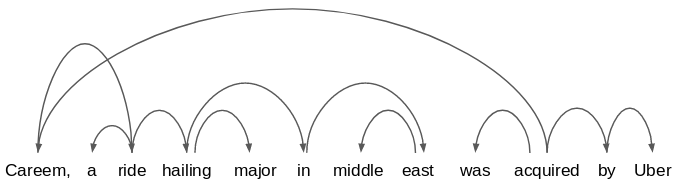

Cukup menakutkan, bukan?

Jangan khawatir! Yang harus kita periksa adalah jalur ketergantungan mana yang umum di antara beberapa kalimat. Metode ini dikenal sebagai pencocokan Subpohon.

Sebagai contoh, jika kita membandingkan pernyataan ini dengan pernyataan sebelumnya:

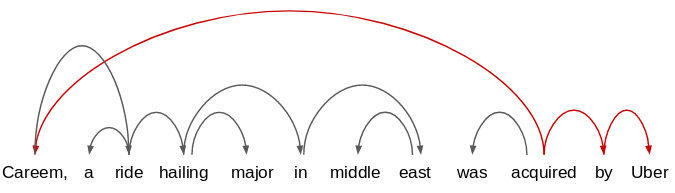

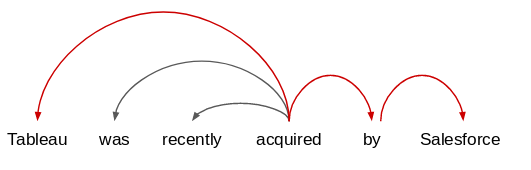

Kita hanya akan mempertimbangkan jalur ketergantungan umum dan mengekstrak entitas dan relasi (yang diperoleh) di antara mereka. Oleh karena itu, relasi yang diekstrak dari kalimat-kalimat ini adalah:
- Salesforce mengakuisisi Tableau
- Uber mengakuisisi Careem

Mari kita coba mengimplementasikan teknik ini di Python. Kita akan menggunakan spaCy lagi karena membuatnya cukup mudah untuk melintasi pohon ketergantungan.

Kita akan mulai dengan melihat tag ketergantungan dan tag POS dari kata-kata dalam kalimat:

In [ ]:
text = "Tableau was recently acquired by Salesforce."
doc = nlp(text)

for tok in doc:
    print(tok.text,"-->",tok.dep_,"-->",tok.pos_)

Tableau --> nsubjpass --> PROPN
was --> auxpass --> AUX
recently --> advmod --> ADV
acquired --> ROOT --> VERB
by --> agent --> ADP
Salesforce --> pobj --> PROPN
. --> punct --> PUNCT


Di sini, tag ketergantungan untuk "Tableau" adalah nsubjpass yang merupakan singkatan dari subjek pasif (karena ini adalah kalimat pasif). Entitas lain "Salesforce" adalah objek dalam kalimat ini dan istilah "acquired" adalah ROOT dari kalimat tersebut yang berarti menghubungkan objek dan subjek.

Mari kita mendefinisikan sebuah fungsi untuk melakukan pencocokan subpohon:

In [ ]:
def subtree_matcher(doc):
    x = ''
    y = ''

    # iterate through all the tokens in the input sentence
    for i,tok in enumerate(doc):
        # extract subject
        if tok.dep_.find("subjpass") == True:
            y = tok.text

        # extract object
        if tok.dep_.endswith("obj") == True:
            x = tok.text

    return x,y

Dalam kasus ini, kita hanya perlu menemukan semua kalimat yang:
- Memiliki dua entitas,
- dan Tidak "diperoleh" sebagai satu-satunya ROOT dalam kalimat

In [ ]:
subtree_matcher(doc)
# subjek pengakuisisi adalah salesforce
# objeknya adl Tableau

('Salesforce', 'Tableau')

Di sini, subjeknya adalah "pengakuisisi" dan objeknya adalah entitas yang diakuisisi. Mari gunakan fungsi yang sama, subtree_matcher(), untuk mengekstrak entitas-entitas yang terkait dengan relasi yang sama ("diakuisisi"):



In [ ]:
text_2 = "Careem, a ride hailing major in middle east, was acquired by Uber."

doc_2 = nlp(text_2)
subtree_matcher(doc_2)

('Uber', 'Careem')

Apakah Anda melihat apa yang terjadi di sini? Kalimat ini memiliki lebih banyak kata dan tanda baca, tetapi tetap saja, logika kami bekerja dan berhasil mengekstrak entitas terkait.

Tapi tunggu - bagaimana jika saya mengubah kalimatnya dari kalimat pasif menjadi kalimat aktif? Akankah logika kita masih bekerja?

In [ ]:
text_3 = "Salesforce recently acquired Tableau."
doc_3 = nlp(text_3)
subtree_matcher(doc_3)

('Tableau', '')

Hal ini tidak sesuai dengan yang kami harapkan. Fungsi tersebut gagal menangkap 'Salesforce' dan salah mengembalikan 'Tableau' sebagai pengakuisisi.

Jadi, apa yang salah? Mari kita pahami pohon ketergantungan dari kalimat ini:

In [ ]:
for tok in doc_3:
    print(tok.text, "-->",tok.dep_, "-->",tok.pos_)

Salesforce --> nsubj --> NOUN
recently --> advmod --> ADV
acquired --> ROOT --> VERB
Tableau --> dobj --> PROPN
. --> punct --> PUNCT


Ternyata fungsi tata bahasa (subjek dan objek) dari istilah 'Salesforce' dan 'Tableau' telah dipertukarkan dalam kalimat aktif. Namun, sekarang tag ketergantungan untuk subjek telah berubah menjadi 'nsubj' dari 'nsubjpass'. Tag ini menunjukkan bahwa kalimat tersebut menggunakan kalimat aktif.

Kita dapat menggunakan properti ini untuk memodifikasi fungsi pencocokan subpohon. Di bawah ini adalah fungsi baru untuk pencocokan subpohon:

In [ ]:
def new_subtree_matcher(doc):
    subjpass = 0
    x = ''
    y = ''

    for i,tok in enumerate(doc):
    # find dependency tag that contains the text "subjpass"
        if tok.dep_.find("subjpass") == True:
            subjpass = 1

    # if subjpass == 1 then sentence is passive
    if subjpass == 1:
        for i,tok in enumerate(doc):
            if tok.dep_.find("subjpass") == True:
                y = tok.text

            if tok.dep_.endswith("obj") == True:
                x = tok.text

    # if subjpass == 0 then sentence is not passive
    else:
        for i,tok in enumerate(doc):
            if tok.dep_.endswith("subj") == True:
                x = tok.text

            if tok.dep_.endswith("obj") == True:
                y = tok.text

    return x,y

In [ ]:
new_subtree_matcher(doc_3)

In [ ]:
new_subtree_matcher(nlp("Tableau was recently acquired by Salesforce."))

('Salesforce', 'Tableau')

In [ ]:
text_4 = "Careem, a ride hailing major in middle east, was acquired by Uber."

doc_4 = nlp(text_4)
new_subtree_matcher(doc_4)

('Uber', 'Careem')

refrence:
- https://github.com/Gozie02/Rule-Based-POS-Matching/blob/main/Information%20Extraction%20using%20SpaCy%20(3).ipynb